In [1]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2

In [2]:
import fastai as meta_fai
import fastai.basics as fai
import fastai.vision as fv
from pathlib import Path
import pandas as pd
import random
import numpy as np
from collections import defaultdict
import gc
import torch
import torchvision.models
import torch.nn as nn
import torch.nn.functional as F
import torch.optim
import math
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils

import PIL
from tqdm import tqdm_notebook as tqdm
from tqdm import trange

# Bug Spray ୧[ ˵ ͡ᵔ ͜ʟ ͡ᵔ ˵ ]୨

In [3]:
get_ipython().config.get('IPKernelApp', {})['parent_appname'] = ""

In [4]:
#!head train_photo_to_biz_ids.csv

In [5]:
#!ls train_photos | head

In [6]:
#!head train.csv

In [7]:
biz_label = pd.read_csv("train.csv").fillna('')

In [8]:
#biz_label.head()

In [9]:
photo_biz = pd.read_csv("train_photo_to_biz_ids.csv")

In [10]:
#photo_biz.head()

In [11]:
bizs, labels = biz_label['business_id'], biz_label['labels']
biz2label = {biz:label for biz,label in zip(bizs, labels)}

In [12]:
#biz2label

In [13]:
bizzes = list(biz2label.keys())

nvalid = 200

random.seed(13) # jajaja ... 13
random.shuffle(bizzes)
valid_biz, train_biz  = bizzes[:nvalid], bizzes[nvalid:]

In [14]:
valid_biz[:4], train_biz[:4]

([3901, 1931, 815, 91], [3865, 3211, 63, 3936])

In [15]:
torch.save(valid_biz, "valid_biz.list")
torch.save(train_biz, "train_biz.list")

In [16]:
photo2biz = {photo:biz for photo,biz in zip(photo_biz['photo_id'], photo_biz['business_id'])}

In [17]:
biz2photos = defaultdict(lambda : [])
for img,biz in photo2biz.items():
    biz2photos[biz].append(img)

In [18]:
biz2photos[3][:3]

[231210, 54476, 276530]

In [19]:
photo_label = photo_biz.copy()
photo_label.business_id = photo_label.business_id.apply(lambda x: biz2label[x])

In [20]:
photo_label.head()

,photo_id,business_id
0,204149,3 8
1,52779,1 2 3 5 6 7
2,278973,1 2 3 4 5 6 7
3,195284,1 2 3 4 5 6 7
4,19992,1 2 3 4 5 6 7


In [21]:
photo_label = photo_label.rename({"business_id":"labels"},axis=1);

In [22]:
photo_label.head()

,photo_id,labels
0,204149,3 8
1,52779,1 2 3 5 6 7
2,278973,1 2 3 4 5 6 7
3,195284,1 2 3 4 5 6 7
4,19992,1 2 3 4 5 6 7


In [23]:
def str2list(label):
    if label != label: return [] # if lbl == NaN
    return [int(x) for x in label.split()]

categories = ["good_for_lunch", "good_for_dinner", "takes_reservations", "outdoor_seating", "restaurant_is_expensive", "has_alcohol", "has_table_service", "ambience_is_classy", "good_for_kids"]

In [24]:
valid_dict = [0]*4001
for biz in valid_biz:
    valid_dict[biz] = 1
    
def is_valid(filename):
    pf = Path(filename)
    f = int(pf.stem)
    return valid_dict[photo2biz[f]]

In [25]:
def load_data(img_size, batch_size, amount=1):
    tfms = fv.get_transforms()
    return (fv.ImageItemList.from_df(photo_label,".",folder="train_photos", suffix='.jpg')
              .filter_by_rand(amount, seed=666)
              .split_by_valid_func(is_valid)
              .label_from_df(label_delim=' ') #dataframe
              .transform(tfms, size=img_size)
              .databunch(bs=batch_size))

In [26]:
data = load_data(224,64, amount=0.1)

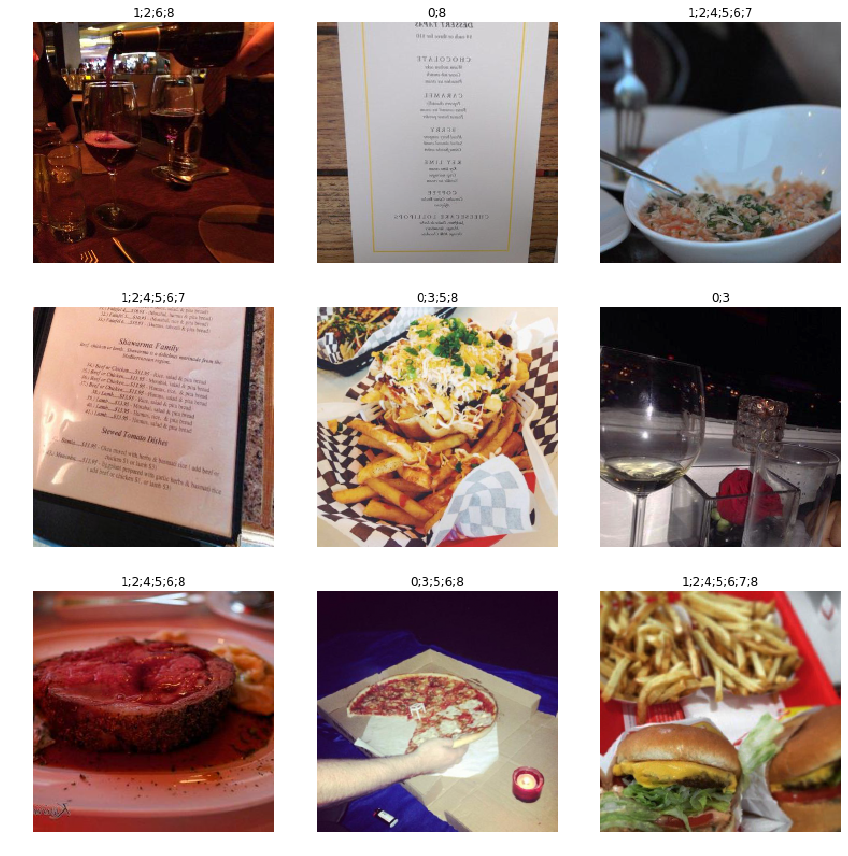

In [27]:
data.show_batch(rows=3)


In [28]:
class F1_Score:
    def __init__(self,thresh:float):
        self.thresh = thresh
        
    def __call__(self,inp,targ):
        return meta_fai.metrics.fbeta(inp, targ, thresh=self.thresh, beta=1.)
    
    def __repr__(self):
        return f"F1({self.thresh})"
    
    @property
    def __name__(self):
        return self.__repr__()

In [29]:
metrics = [F1_Score(t) for t in [0.3, 0.4, 0.45, 0.5, 0.55, 0.6, 0.7]]

In [30]:
learner = fv.create_cnn(data, fv.models.resnet101, metrics=metrics, wd=0.1)

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


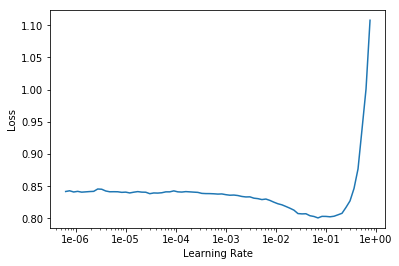

In [31]:
learner.lr_find(); learner.recorder.plot()

In [ ]:
learner.fit_one_cycle(1,9e-2)

In [ ]:
learner.fit_one_cycle(5,1e-3)

In [ ]:
learner.save("simple_cnn_101")

In [ ]:
learner.unfreeze()

In [ ]:
learner.lr_find(); learner.recorder.plot()

In [ ]:
learner.fit_one_cycle(5,1e-2)

In [ ]:
learner.save("simple_unfroze_cnn_101")

# aun no se para que sirve esto :v

In [ ]:
class SimpleTensorDataset(Dataset):
    def __init__(self, features, labels):
        super().__init__()
        assert len(features) == len(labels)
        self.features = [torch.tensor(f).float().cpu() for f in features]
        self.labels = [torch.tensor(l).float().cpu() for l in labels]
        
    def __len__(self):
        return len(self.features)

    def __getitem__(self, i):
        return self.features[i], self.labels[i]